# Домашнее задание по НСТ 
## Спектрограммы и алгоритм Гриффина-Лима
## Самойлов Александр СКБ 222

## 1. Извлечение речевых представлений

Здесь мы попробуем сами попреобразовывать сырое аудио, которые мы обычно получаем с микрофона с определенной частотой дискретизации, в спектрограммы, мел-спектрограмма( с мел-шкалой) и коэффициенты MFCC.

### Посмотрим:
- Как реализовать кратковременное преобразование Фурье (STFT);
- Как составить частотную спектрограмму из серии смещённых STFT;
- Как использовать мел-шкалу  для сжатия частотной спектрограммы в мел-спектрограмму;
- Как получить мел-частотные кепстральные коэффициенты (MFCC) из мел-спектрограммы.

---

## 2. Реконструкция аудио из речевых представлений

Восстановим аудио из мел-спектрограмм и MFCC при помощи алгоритма Гриффина-Лима.

### Посмотрим:
- Как восстановить частотную спектрограмму из мел-спектрограммы;
- Как восстановить аудио из частотной спектрограммы с помощью алгоритма Гриффина-Лима;
---

## Про что вообще ноутбук??
Существует такая задача, как преобразование текста в звук (Text-to-speech). На сегодняшний день представлено уже множество решений, с которыми мы сталкиваемся чаще, чем думаем. Например, те же видео shorts в YouTube c роботизированной озвучкой.
Рассмотрим одно из решений, искусственная нейронная сеть синтеза речи Tacotron2 от DeepMind: 
![img](https://pytorch.org/assets/images/tacotron2_diagram.png)

---
__Классно, что есть уже такие крутые решения, как Tacotron2. Понятно, что мы из текста как-то получили какую-то картинку, а как мы из нее извлеки звук? Что вообще происходит и какая интуиция стоит за последним действием? Хотелось бы как-то наглядно проследить логику задачи. Именно про это будет этот ноутбук__ 

## Начнем
Итак, звук...Посмотрим с чем имеем дело

In [2]:
# Импортируем необходимые библиотеки
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
import librosa


# Посмотрим аудио
display(Audio("sample1.wav")) # That's no moon it's a space station
display(Audio("sample2.wav")) # Help me, Obi Wan Kenobi. You're my only hope

__Звук__ может быть записан в виде серии __амплитуд__ давления воздуха, измеренных в определённой точке с определённой частотой дискретизации с использованием микрофона. \
Типичные частоты дискретизации:
* 16 кГц
* 22 кГц
* 48 кГц

Посмотрим еще раз на наши примеры и частоту дискретизации.

Длина : 3.947392290249433 секунд с частотой дискретизации 22050


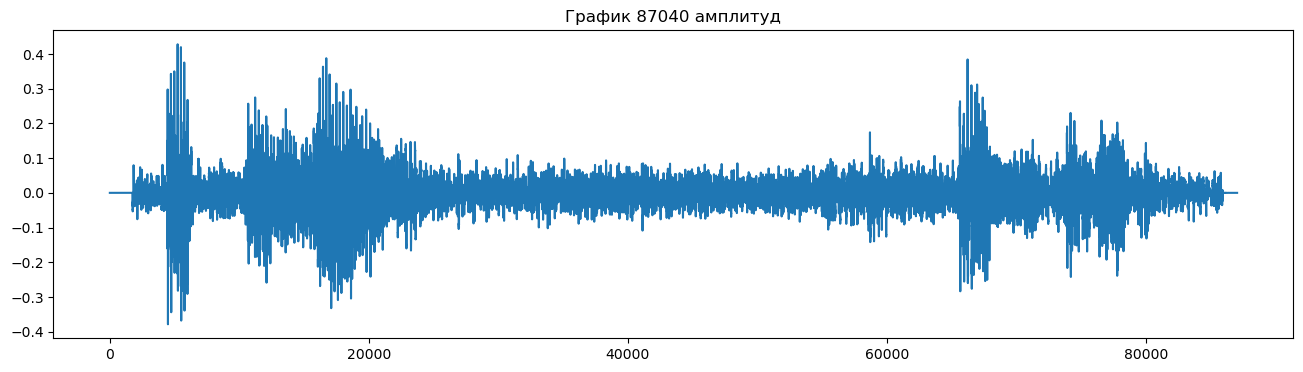

In [4]:
amplitudes, sample_rate = librosa.core.load("sample1.wav") # Поисследуем наши аудио

display(Audio(amplitudes, rate=sample_rate))

print("Длина : {} секунд с частотой дискретизации {}".format(amplitudes.shape[0] / sample_rate, sample_rate))

# Повизуализируем
plt.figure(figsize=[16, 4])
plt.title("График {} амплитуд".format(len(amplitudes)))
plt.plot(amplitudes);
plt.show()

Как вы можете видеть, в 4-секундном аудиосэмпле, где произнесено всего __7 слов__, содержится __87040__ амплитудных значений! Это чрезвычайно сложно обрабатывать напрямую, так как данных слишком много! Это значительно превышает типичную длину последовательности NLP. Поэтому нам необходимо сжать эту информацию до более управляемого размера!

## Часть 1: Извлечение речевых представлений

Рассмотрим два представления мел-спектрограмму и мел-частотные кепстральные коэффициенты (MFCC).

### Теоретический блок

Работа с аудиосигналами начинается с понимания их физических свойств и методов представления, которые помогают в анализе и обработке. Одной из ключевых задач является оценка энергии и мощности сигнала, а также эффективное сжатие динамического диапазона. Эти концепции лежат в основе большинства современных алгоритмов обработки звука, таких как распознавание речи, сжатие и очистка сигналов от шума.

---

#### Энергия и мощность: как измерить сигнал

**Энергия** и **мощность** являются фундаментальными характеристиками звукового сигнала. Энергия определяет общую "силу" сигнала за весь период времени, а мощность показывает, насколько сильным сигнал является в среднем.

Для дискретного сигнала длины $T$, заданного как последовательность амплитуд $\{f_n\}_{1:T}$, энергия вычисляется как сумма квадратов всех значений:

$$
E = \sum_{n=1}^{T} f_n^2
$$

Мощность, в свою очередь, представляет собой среднее значение квадрата амплитуды сигнала:

$$
P = \frac{1}{T} \sum_{n=1}^{T} f_n^2
$$

Для реальных приложений часто важно анализировать сигнал на небольших временных интервалах (окнах) длиной $\tau$. В таком случае энергия и мощность сигнала в окне с началом в точке $t$ рассчитываются как:

$$
E_t = \sum_{n=t}^{t + \tau} f_n^2, \quad P_t = \frac{1}{\tau} \sum_{n=t}^{t + \tau} f_n^2
$$

Это позволяет определить динамику изменения сигнала во времени. Поскольку среднее значение звуковых сигналов (особенно речи) часто близко к нулю, мощность сигнала $P_t$ эквивалентна его дисперсии:

$$
P_t = \sigma_t^2
$$

**Применение:**  
- Мощность сигнала помогает обнаружить, где в аудиофайле есть активность (например, речь или громкий звук).
- Вычисление энергии и мощности используется в методах распознавания речи, очистке аудио от шума и разделении сигналов.

---

#### Преобразование мощности в децибелы

Для более удобной интерпретации мощности звука она часто преобразуется в **децибелы** — логарифмическую шкалу, которая соответствует человеческому восприятию громкости. Формула преобразования мощности в децибелы выглядит так:

$$
P_t(dB) = 10\log_{10}\sigma_t^2 = 20\log_{10}\sigma_t
$$

Эта шкала удобна для сравнения сигналов различной интенсивности. Например, отношение мощности сигнала к мощности шума (Signal-to-Noise Ratio, **SNR**) также измеряется в децибелах:

$$
SNR_{dB} = 20\log_{10}\frac{\sigma(f_{\text{signal}})}{\sigma(f_{\text{noise}})}
$$

**Применение:**  
- Используется для оценки качества записи (например, в шумных условиях).
- Помогает в улучшении сигналов за счёт повышения $SNR$ при обработке аудио.

---

#### Сжатие динамического диапазона: μ-law

Звуковой сигнал имеет огромный динамический диапазон (разница между самыми тихими и громкими звуками). Это создает трудности при обработке, поскольку амплитуды громких звуков могут "перекрыть" тихие. Для решения этой проблемы используется **логарифмическое сжатие**, например, метод **μ-law**.

Формула сжатия:

$$
F(x) = \operatorname{sgn}(x) \cdot \frac{\ln(1 + \mu |x|)}{\ln(1 + \mu)}, \quad -1 \leq x \leq 1
$$

где:
- $\mu = 2^{\text{bits}} - 1$ определяет степень сжатия,
- $x$ — нормализованный сигнал (в диапазоне от $-1$ до $1$).

![img](./quantization_mulaw.png-1.png)

##### Почему μ-law важно?

1. **Сглаживание громких амплитуд:**  
   Высокие амплитуды сжимаются, чтобы они не "заглушали" остальные части сигнала.

2. **Повышение точности для тихих звуков:**  
   Маленькие амплитуды получают большее количество бит при квантовании, что снижает шум и улучшает качество.

**Применение:**
- Применяется перед вычислением спектральных характеристик, таких как MFCC, для повышения точности анализа.
---

#### Применение мощности: Voice Activity Detection (VAD)

Одним из простых, но важных приложений энергии и мощности является **детекция голосовой активности (VAD)**. Этот метод позволяет выделить участки речи из общего аудиосигнала.

**Как работает VAD?**
- Сигнал делится на скользящие окна фиксированной длины.
- Для каждого окна вычисляется энергия или мощность сигнала.
- Участки с мощностью, превышающей заданный порог, считаются активной речью, а остальные — тишиной или шумом.

**Применение:**  
- Распознавание речи: помогает фокусироваться только на участках, содержащих слова.
- Оптимизация обработки: позволяет игнорировать тихие фрагменты, что экономит вычислительные ресурсы.
- Коммуникационные системы: улучшает качество передачи голоса, исключая ненужный шум.
---
### Short-Time Fourier Transforms (STFT) и Спектограммы
Типичным решением нашей проблемы является использование __спектограмм:__ вместо сохранения тысяч амплитуд. Мы можем выполнить __преобразование Фурье__, чтобы определить, какие периоды преобладают в каждый момент времени. Более формально, спектрограмма применяет __Кратковременное преобразование Фурье (STFT)__ к небольшим перекрывающимся окнам временного ряда амплитуд:
#### Кратковременное преобразование Фурье (STFT)

STFT (Short-Time Fourier Transform) — это метод анализа сигнала, который разбивает его на небольшие перекрывающиеся окна и применяет преобразование Фурье к каждому из них. Это позволяет определить спектральные характеристики сигнала во времени.
Преобразование Фурье в общем виде описывается следующими формулами: \
[**Теорема о свертке**](https://en.wikipedia.org/wiki/Convolution_theorem): Свертка в пространстве времени это перемножение в пространстве частот и наоборот. \
Прямое (**time -> frequency**) и обратное (**frequency -> time**), где $\omega$ - частота:
$$
F(\omega) = \int\limits_{-\infty}^{\infty} f(t) e^{-2\pi i t \omega} \, dt \quad \text{(прямое)}
$$
$$
f(t) = \int\limits_{-\infty}^{\infty} F(\omega) e^{2\pi i t \omega} \, d\omega \quad \text{(обратное)}
$$
Однако обычное преобразование Фурье применяет анализ ко всему сигналу сразу, теряя временную локализацию. Чтобы сохранить информацию о том, как частоты распределены во времени, используется подход с разбиением сигнала на перекрывающиеся окна. К каждому фрагменту нужно применить оконную функцию, чтобы сгладить концы, потому что когда сигнал "обрезается" на границах окна, возникают резкие переходы, которые могут добавить шум в спектр. Надо снизить эффекты утечки спектра, т.е. если этого не делать  энергия частоты "утекает" на соседние частоты, создавая искажения в спектральном представлении. \
При работе с цифровыми сигналами используется дискретное преобразование Фурье (DFT), которое вычисляется как:

$$
X_k = \sum_{n=0}^{N-1} x_n e^{-i \frac{2\pi}{N} k n} \quad \text{(прямое)}
$$
$$
x_k = \frac{1}{N} \sum_{n=0}^{N-1} X_n e^{i \frac{2\pi}{N} k n} \quad \text{(обратное)}
$$

Результатом DFT является спектр сигнала, $\{X_k\}_{k=1}^K$, где каждое $X_k$ — это комплексное число с амплитудой $|X_k|$ и фазой $\phi_k$:

$$
X_k = |X_k| e^{i \phi_k}
$$
Мощность сигнала - $|X_k|^2$

---
![img](https://github.com/yandexdataschool/speech_course/blob/d60c1d694dc263dd0e7dffd7f19e168ca55dc9e5/week_02/stft-scheme.jpg?raw=true)

__Спектрограмма__ — это визуальное представление энергии сигнала в частотном пространстве за определённые временные интервалы. Вместо хранения тысяч амплитуд, можно применять **STFT** к небольшим перекрывающимся окнам временного ряда амплитуд, чтобы узнать, какие частоты доминируют в каждый момент времени.

#### Как работает STFT?

Рассмотрим аудиосигнал $\mathbf{x}_{1:t}$. Результатом STFT является **комплексное значение**. Абсолютное значение $\text{STFT}(\mathbf{x}_{1:t})$ показывает **амплитуды** каждой частоты, а квадрат абсолютного значения — **мощность** сигнала на каждой частоте. Обычно мы используем именно спектр мощности:

$$
\mathbf{X}_{1:t} = |\text{STFT}(\mathbf{x}_{1:t})|^2
$$

Эти преобразования затем объединяются в частотно-временную матрицу — **частотную спектрограмму**. Чтобы получить более "ровное" распределение мощностей, особенно в области высоких частот, применяется логарифмическое преобразование:

$$
\mathbf{s}_{\tau} = \log \left[|\text{STFT}(\mathbf{x}_{T \cdot (\tau-1) : T \cdot \tau})|^2\right]
$$
$$
\mathbf{S} = \mathbf{s}_{1:T}
$$

Когда STFT применяется к **реальному сигналу** (например, аудио), его частотный спектр обладает свойством **сопряжённой симметрии**:

$$
X(-f) = \overline{X(f)}
$$
Вывод
$$
X_m = \sum_{n=0}^{N-1} x_n \exp\left(-j 2\pi \frac{m}{N} n\right)
$$
$$
X_{N-m} = \sum_{n=0}^{N-1} x_n \exp\left(-j 2\pi \frac{N-m}{N} n\right) = \sum_{n=0}^{N-1} x_n \exp\left(-j 2\pi n + j 2\pi \frac{m}{N} n\right) = \sum_{n=0}^{N-1} x_n \exp\left(j 2\pi \frac{m}{N} n\right) = (X_m)^*
$$

Это означает, что отрицательные частоты ($-f$) являются зеркальным отражением положительных частот ($f$), причём их значения комплексно сопряжены. Таким образом:

- Амплитуды отрицательных частот идентичны амплитудам положительных частот.
- Фазы отрицательных частот противоположны фазам положительных частот.

__КРУТО, МЫ СЖАЛИ АУДИО, ДЕЛОВ-ТО!!! Или нет...__
![img](https://medialeaks.ru/wp-content/uploads/2021/10/1280h720-1.jpg)

### Мел-спектограммы и MFCC

Хотя спектрограмма сокращает количество данных по временной оси, размер частотной оси остаётся слишком большим для обработки. Типичная человеческая речь охватывает частоты от 20 Гц до 20 кГц, что приводит к спектрограмме с диапазоном частот от 0 до 20000 Гц — слишком большим для удобного использования инструментов, таких как нейронные сети.

#### Преобразование в мел-спектрограмму

Стандартный подход для уменьшения размера данных состоит в преобразовании спектрограммы в **мел-спектрограмму**, используя [мел-шкалу](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). Чувствительность человеческого слуха экспоненциально уменьшается с увеличением частоты. Поэтому можно объединить более высокие частоты в группы (или "корзины") и сжать спектрограмму.

Для этого вычисляется **мел-основа** $\mathbf{M}$, и спектрограмма мощности по частотам преобразуется в мел-спектрограмму с помощью матричного умножения:

$$
\textbf{MS} = \mathbf{M} \cdot \textbf{S}
$$

#### Преобразование частот в мелы

Частоты преобразуются в мелы по следующей формуле:

$$
m = 2595\log_{10}(1 + \frac{f}{700})
$$

---

#### Обратное преобразование

Для восстановления частотной спектрограммы из мел-спектрограммы используется [псевдообратная матрица Мура-Пенроуза](https://ru.wikipedia.org/wiki/Псевдообратная_матрица). Соотношение выглядит следующим образом:

$$
\hat{\mathbf{S}} = (\mathbf{F}^T\mathbf{F})^{-1}\mathbf{F}^T\mathbf{M}
$$

---

### Мел-частотные кепстральные коэффициенты (MFCC)

Кепстральные коэффициенты (MFCC, Mel-Frequency Cepstral Coefficients) — это числовые характеристики сигнала, которые представляют его спектральное содержание в компактной и удобной для анализа форме. Они широко используются в задачах обработки речи, таких как распознавание речи и классификация звуков.

#### Основная идея

MFCC извлекают ключевую информацию из спектра сигнала, отделяя:
- **Медленно изменяющиеся компоненты** (например, характеристики вокального тракта).
- **Быстро изменяющиеся компоненты** (например, особенности возбуждения звука).

#### Как вычисляются MFCC?

1. **Преобразование сигнала в мел-спектрограмму**  
   Сначала спектрограмма мощности преобразуется в мел-спектрограмму
2. **Логарифмическое преобразование мощности**  
   Применяется логарифм для сжатия диапазона мощностей:

   $$
   \textbf{MS}_{\text{log}} = \log(\textbf{MS})
   $$

3. **Обратное преобразование Фурье (DCT)**  
   Для получения MFCC применяется дискретное косинусное преобразование (DCT), чтобы извлечь обобщённые спектральные характеристики:

   $$
   \textbf{MFCC} = \text{DCT}(\textbf{MS}_{\text{log}})
   $$

### STFT

(87040,)


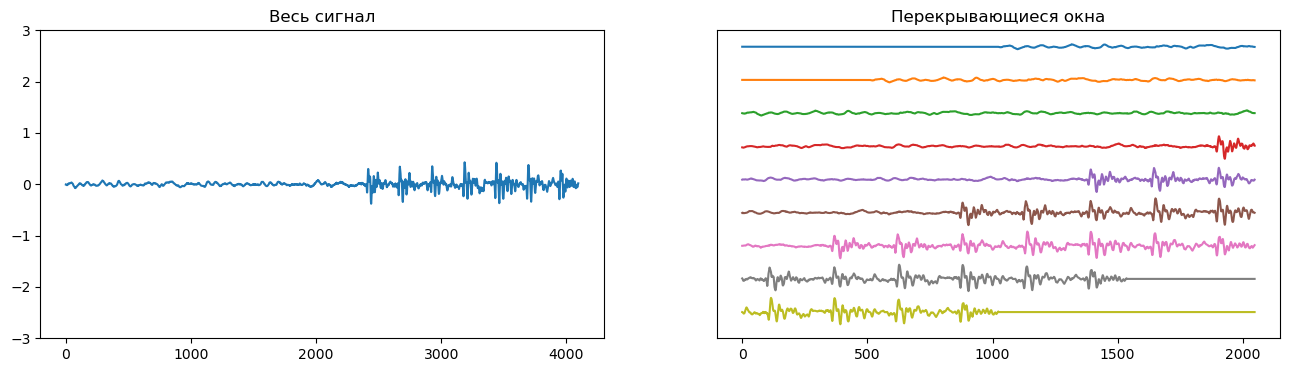

In [8]:
# Некоторые вспомогательные функции:

# Разделяем временной ряд на перекрывающиеся окна
def slice_into_frames(amplitudes, window_length, hop_length):
    """
    Разбивает сигнал на перекрывающиеся окна фиксированной длины.
    Используется паддинг для обработки краевых данных.

    :param amplitudes: массив амплитуд сигнала
    :param window_length: длина окна
    :param hop_length: шаг между окнами
    :return: массив окон с перекрытием
    """
    return librosa.util.frame(
        np.pad(amplitudes, int(window_length / 2), mode='constant'),  # Добавляем паддинг
        frame_length=window_length, hop_length=hop_length
    )
    # Результирующая форма массива: [window_length, num_windows]

# Пример данных
dummy_amps = amplitudes[2048:6144]  # Берём часть сигнала для примера
dummy_frames = slice_into_frames(dummy_amps, 2048, 512)  # Разбиваем на окна
print(amplitudes.shape)  # Печатаем форму исходного сигнала

# Визуализация сигналов
plt.figure(figsize=[16, 4])

# Весь временной ряд
plt.subplot(121, title='Весь сигнал', ylim=[-3, 3])
plt.plot(dummy_amps)

# Перекрывающиеся окна
plt.subplot(122, title='Перекрывающиеся окна', yticks=[])
for i, frame in enumerate(dummy_frames.T):  # Перебираем окна
    plt.plot(frame + 10 - i)  # Смещаем для визуализации
plt.show()

# Функция отображения спектограммы
def plot_spectrogram(spectrogram): ### ПОЧЕМУ ТУТ
    fig, ax = plt.subplots(figsize=(10, 2))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)

    fig.canvas.draw()
    plt.show()

    return fig


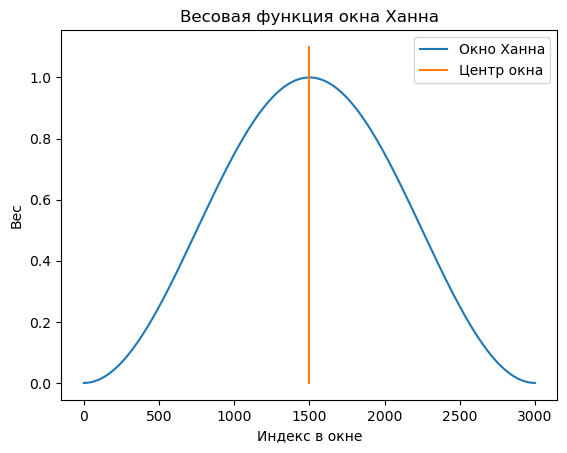

In [12]:
# Перед выполнением DFT амплитуды масштабируются с помощью весов
# Используемая весовая функция имеет большие значения в центре окна и малые на его краях

# Длина окна
# Окно Ханна (и другие оконные функции) уменьшают амплитуды на краях окна.
# Если окно слишком короткое, важные участки сигнала могут попасть в зону
# Поэтому возьмем окно побольше
dummy_window_length = 3000

# Генерация весовой функции окна Ханна (Hann window)
dummy_weights_window = librosa.filters.get_window('hann', dummy_window_length, fftbins=True)

# Визуализация весовой функции
plt.plot(dummy_weights_window, label='Окно Ханна')  # Отображаем весовую функцию
plt.plot([1500, 1500], [0, 1.1], label='Центр окна')  # Отмечаем центр окна
plt.legend()  # Добавляем легенду для графика
plt.title('Весовая функция окна Ханна')  # Заголовок графика
plt.xlabel('Индекс в окне')  # Подпись оси X
plt.ylabel('Вес')  # Подпись оси Y
plt.show()

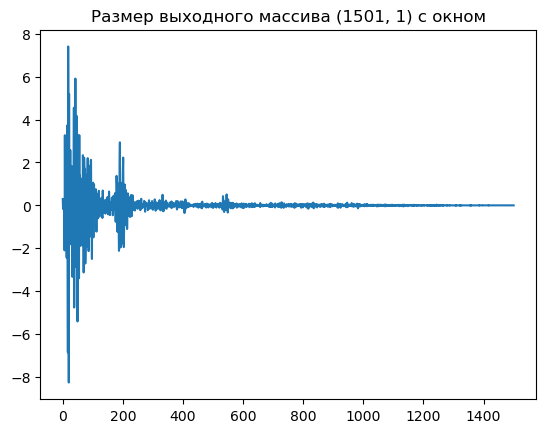

In [18]:
# Выполняем FFT с применением весовой функции окна
dummy_fft = np.fft.rfft(
    dummy_amps[:3000, None] * dummy_weights_window[:, None],  # Применяем окно Ханна к сигналу
    axis=0  # Преобразование вдоль оси 0 (временная ось)
)  
# Выводим спектр для одного окна (реальная часть)
plt.plot(np.real(dummy_fft)[:, 0])  # Визуализация реальной части спектра
plt.title("Размер выходного массива {} c окном".format(dummy_fft.shape))
plt.show()

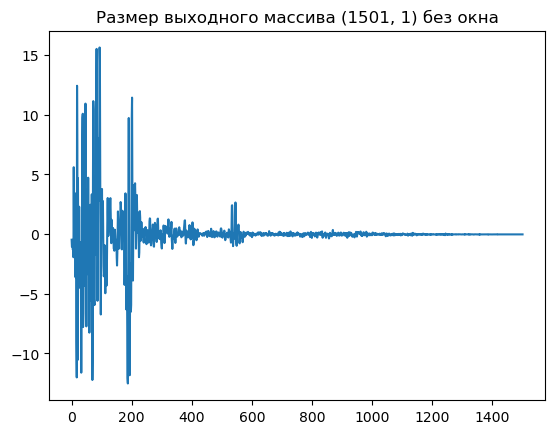

In [26]:
# Выполняем FFT без применения весовой функции окна
dummy_fft = np.fft.rfft(
    dummy_amps[:3000, None],  # Сигнал без взвешивания
    axis=0  # Преобразование вдоль оси 0
)
# Выводим спектр для одного окна (реальная часть)
plt.plot(np.real(dummy_fft)[:, 0])  # Визуализация реальной части спектра
plt.title("Размер выходного массива {} без окна".format(dummy_fft.shape)) # Печатаем размер выходного массива
plt.show()

__Приступим к резализации STFT__

In [29]:
def get_STFT(amplitudes, window_length=2048, hop_length=512):
    """
    Вычисляет кратковременное преобразование Фурье (STFT) для сигнала.
    
    :param amplitudes: float [num_amplitudes] — временной ряд амплитуд звука
    :param window_length: int — длина окна, к которому применяется FFT
    :param hop_length: int — шаг между соседними окнами (временной сдвиг)
    :returns: stft — кратковременное преобразование Фурье (комплексные значения частотных компонент)
    """
    # Разбиваем амплитуды на перекрывающиеся окна [window_length, num_frames]
    # Используется вспомогательная функция slice_into_frames для разбиения сигнала
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # Создаём весовую функцию окна Ханна [window_length]
    # Она используется для сглаживания краёв сигнала перед FFT
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    fft_weights = librosa.util.pad_center(fft_weights, size=window_length)  # Центрируем веса окна

    # Применяем преобразование Фурье (FFT) к каждому окну, масштабируя амплитуды весами окна
    # Используем только положительные частоты (np.fft.rfft) и обрезаем до cutoff
    # cutoff = window_length / 2 + 1 — это число частотных компонент, доступных для реального сигнала
    cutoff = int(window_length / 2 + 1)
    stft = np.array([
        np.fft.rfft(frame * fft_weights)[:cutoff]  # FFT для каждого окна
        for frame in frames.T  # Перебираем окна (по временной оси)
    ]).T  # Транспонируем, чтобы вернуть результат в формате [num_frequencies, num_frames]

    return stft


In [37]:
# Проверим себя с реализацией из librosa

amplitudes1, s1 = librosa.core.load("./sample1.wav")
amplitudes2, s2 = librosa.core.load("./sample2.wav")

ref1 = librosa.stft(amplitudes1, win_length=2048, hop_length=512)
ref2 = librosa.stft(amplitudes2, win_length=2048, hop_length=512)

assert np.allclose(get_STFT(amplitudes1), ref1, rtol=1e-4, atol=1e-4)
assert np.allclose(get_STFT(amplitudes2), ref2, rtol=1e-4, atol=1e-4)

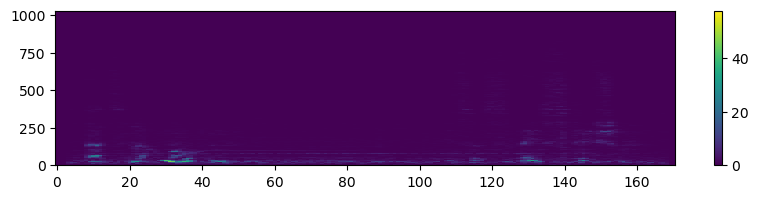

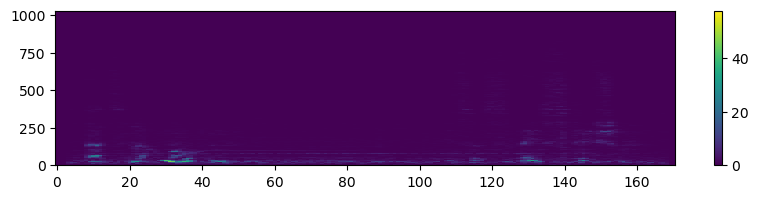

In [41]:
plot_spectrogram(np.abs(get_STFT(amplitudes1))) # Ура что-то есть, нарисуем полученные результаты

In [43]:
def get_spectrogram(amplitudes, window_length=2048, hop_length=512):
    """
    Вычисляет спектрограмму мощности из временного ряда амплитуд звука.
    
    :param amplitudes: float [num_amplitudes] — временной ряд амплитуд звука
    :param window_length: int — длина окна, к которому применяется FFT
    :param hop_length: int — шаг между соседними окнами (временной сдвиг)
    :returns: spectrogram — спектрограмма мощности [n_freq, duration]
    """
    # Шаг I: Вычисляем кратковременное преобразование Фурье (STFT)
    # Используем функцию get_STFT, которая возвращает частотные компоненты
    stft = get_STFT(amplitudes, window_length, hop_length)
    
    # Проверяем, что размер STFT соответствует ожидаемым значениям:
    # - window_length // 2 + 1 — число частотных компонент (только положительные частоты)
    # - len(amplitudes) // hop_length + 1 — число временных окон
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // hop_length + 1)
    
    # Шаг II: Преобразуем STFT в спектрограмму мощности
    # Амплитуда (модуль комплексного числа) для каждой частоты и окна возводится в квадрат
    # Это даёт мощность сигнала на каждой частоте:
    # |stft|^2 = мощность
    spectrogram = np.abs(stft) ** 2
    
    return spectrogram

In [47]:
# Проверим себя с реализацией из librosa
from librosa.core.spectrum import _spectrogram as magnitude_spectrogram

amplitudes1, s1 = librosa.core.load("./sample1.wav")
amplitudes2, s2 = librosa.core.load("./sample2.wav")

ref1, _ = magnitude_spectrogram(y=amplitudes1, win_length=2048)
ref2, _ = magnitude_spectrogram(y=amplitudes2, win_length=2048)


assert np.allclose(get_spectrogram(amplitudes1), ref1**2, rtol=1e-4, atol=1e-4)
assert np.allclose(get_spectrogram(amplitudes2), ref2**2, rtol=1e-4, atol=1e-4)

In [51]:
# Перепишес нашу функции отрисовки спектограмм
def plot_spectrogram(spectrogram, text=None, x_label="Time", y_label="Value", figsize=(16, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    if text:
        plt.title(text)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar(im, ax=ax, use_gridspec=True)
    
    fig.canvas.draw()
    plt.show()

    return fig

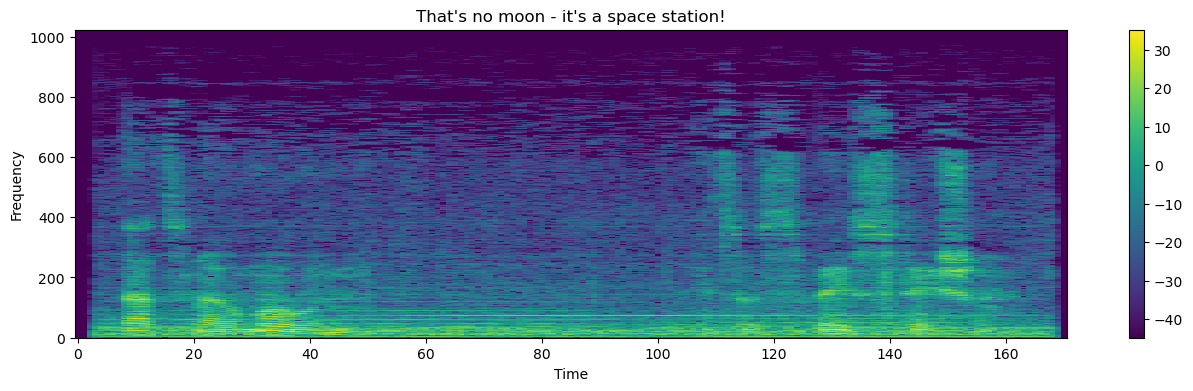

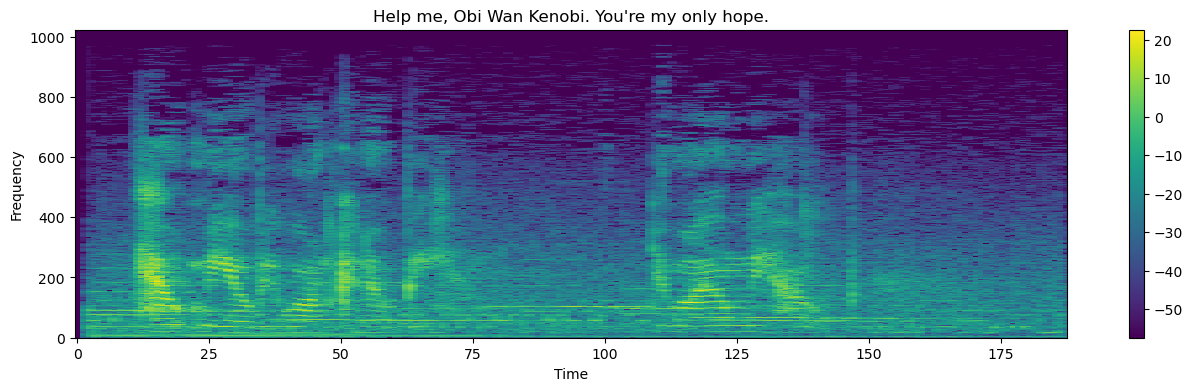

In [55]:
# Вот наши мощностные спектограммы
plot_spectrogram(
    librosa.power_to_db(get_spectrogram(amplitudes1)),
    text = "That's no moon - it's a space station!",
    x_label = "Time",
    y_label = "Frequency"
)

plot_spectrogram(
    librosa.power_to_db(get_spectrogram(amplitudes2)),
    text = "Help me, Obi Wan Kenobi. You're my only hope.",
    x_label = "Time",
    y_label = "Frequency"
)
plt.close()

### Мел-базиз и мел-спектограммы

/var/folders/89/bv65zp913xlglr6hq8_3m4j00000gn/T/ipykernel_41161/107144790.py:7: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = librosa.filters.mel(sr=22050, n_fft=2048, n_mels=128, fmin=1, fmax=12000)


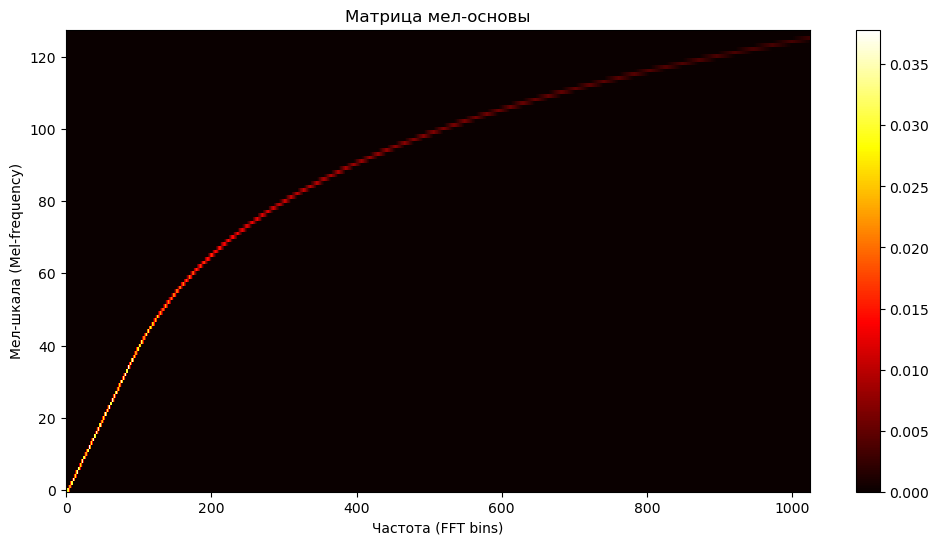

In [57]:
# Создаём матрицу мел-основы (mel-basis), которая будет использоваться для преобразования спектра в мел-спектрограмму
# sr=22050 — частота дискретизации сигнала
# n_fft=2048 — размер окна для FFT
# n_mels=128 — количество мел-шкальных частот (число выходных "корзин")
# fmin=1 — минимальная частота (1 Гц)
# fmax=12000 — максимальная частота (12 кГц)
mel_basis = librosa.filters.mel(sr=22050, n_fft=2048, n_mels=128, fmin=1, fmax=12000)

# Визуализация матрицы мел-основы
plt.figure(figsize=[12, 6])
plt.title("Матрица мел-основы")  # Заголовок графика
plt.xlabel("Частота (FFT bins)")  # Подпись оси X — частоты из FFT
plt.ylabel("Мел-шкала (Mel-frequency)")  # Подпись оси Y — мел-шкала
plt.imshow(
    mel_basis,  # Отображаем мел-основу
    origin='lower',  # Начало оси Y — внизу
    cmap=plt.cm.hot,  # Цветовая карта "горячая" для наглядности
    interpolation='nearest',  # Интерполяция между значениями отключена
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.colorbar(use_gridspec=True)  # Отображение цветовой шкалы
plt.show()


In [60]:
mel_basis.shape # Размер базиса

(128, 1025)

In [62]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Вычисляет мел-спектрограмму из временного ряда амплитуд звука.
    
    :param amplitudes: float [num_amplitudes] — временной ряд амплитуд звука
    :param sample_rate: int — частота дискретизации сигнала (число амплитуд в секунду)
    :param n_mels: int — количество мел-компонент (каналов мел-спектрограммы)
    :param window_length: int — длина окна, к которому применяется FFT
    :param hop_length: int — шаг между соседними окнами
    :param fmin: float — минимальная частота анализа (в Гц)
    :param fmax: float — максимальная частота анализа (в Гц)
    :returns: mel_spectrogram — мел-спектрограмма [n_mels, duration]
    """
    # Шаг I: Вычисляем спектрограмму мощности
    # Спектрограмма мощности (power spectrogram) показывает энергию сигнала для каждой частоты и временного окна
    spectrogram = get_spectrogram(amplitudes, window_length=window_length, hop_length=hop_length)
    
    # Шаг II: Создаём матрицу мел-основы
    # Матрица преобразует частоты спектрограммы в мел-шкалу, учитывая восприятие частот человеком
    mel_basis = librosa.filters.mel(
        sr=sample_rate,  # Частота дискретизации сигнала
        n_fft=window_length,  # Размер FFT (длина окна)
        n_mels=n_mels,  # Число мел-компонент (корзин)
        fmin=fmin,  # Минимальная частота
        fmax=fmax  # Максимальная частота
    )
    # Матрица мел-основы имеет размер [n_mels, window_length / 2 + 1]
    
    # Шаг III: Преобразуем спектрограмму в мел-спектрограмму
    # Умножаем спектрограмму на матрицу мел-основы
    # Альтернатива (комментирована): np.einsum("kj,ik->ij", spectrogram, mel_basis, optimize=True)
    mel_spectrogram = mel_basis @ spectrogram  # Прямое матричное умножение
    
    # Проверяем, что размер мел-спектрограммы соответствует ожидаемому:
    # [n_mels, число временных окон]
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // hop_length + 1)
    
    return mel_spectrogram

In [66]:
# Проверим, с librosa реализацией

amplitudes1, s1 = librosa.core.load("./sample1.wav")
amplitudes2, s2 = librosa.core.load("./sample2.wav")

ref1 = librosa.feature.melspectrogram(y=amplitudes1, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
ref2 = librosa.feature.melspectrogram(y=amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)

assert np.allclose(get_melspectrogram(amplitudes1), ref1, rtol=1e-4, atol=1e-4)
assert np.allclose(get_melspectrogram(amplitudes2), ref2, rtol=1e-4, atol=1e-4)

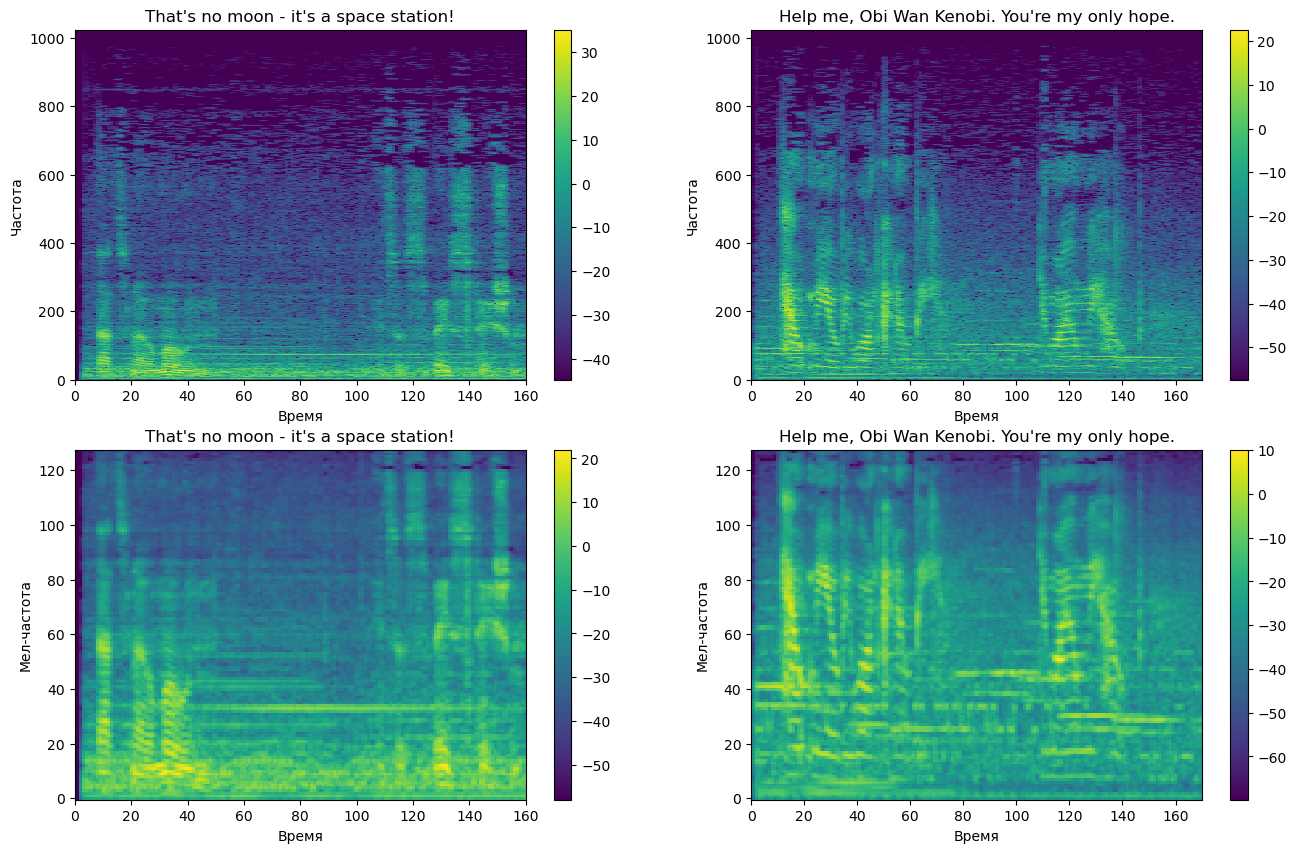

In [70]:
# Сравнение мел-спектрограмм для двух звуковых сэмплов

# Создаём график с 4 подграфиками
plt.figure(figsize=[16, 10])

# --- Спектрограмма мощности для первого сэмпла ---
plt.subplot(2, 2, 1)
plt.title("That's no moon - it's a space station!")  # Заголовок графика
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Частота")  # Ось Y — частотная ось
# Отображаем спектрограмму мощности в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_spectrogram(amplitudes1)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 160)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- Спектрограмма мощности для второго сэмпла ---
plt.subplot(2, 2, 2)
plt.title("Help me, Obi Wan Kenobi. You're my only hope.")  # Заголовок графика
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Частота")  # Ось Y — частотная ось
# Отображаем спектрограмму мощности в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_spectrogram(amplitudes2)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 170)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- Мел-спектрограмма для первого сэмпла ---
plt.subplot(2, 2, 3)
plt.title("That's no moon - it's a space station!")  # Заголовок графика
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Мел-частота")  # Ось Y — мел-частотная ось
# Отображаем мел-спектрограмму в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_melspectrogram(amplitudes1)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 160)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- Мел-спектрограмма для второго сэмпла ---
plt.subplot(2, 2, 4)
plt.title("Help me, Obi Wan Kenobi. You're my only hope.")  # Заголовок графика
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Мел-частота")  # Ось Y — мел-частотная ось
# Отображаем мел-спектрограмму в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_melspectrogram(amplitudes2)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 170)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# Отображаем графики
plt.show()

# Примечание:
# Второй сэмпл имеет более высокую среднюю частоту, 
# что соответствует разнице в голосах (например, различие между мужским и женским голосом).

### MFCC Coefficients

In [72]:
def get_MFCC(amplitudes, n_mfcc=128, sample_rate=22050, n_mels=128,
             window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Вычисляет мел-частотные кепстральные коэффициенты (MFCC) из временного ряда амплитуд звука.
    
    :param amplitudes: float [num_amplitudes] — временной ряд амплитуд звука
    :param sample_rate: int — частота дискретизации (число отсчётов в секунду)
    :param n_mfcc: int — количество кепстральных коэффициентов для сохранения
    :param n_mels: int — количество мел-компонент
    :param window_length: int — длина окна, к которому применяется FFT
    :param hop_length: int — шаг между соседними окнами
    :param fmin: float — минимальная частота для анализа (в Гц)
    :param fmax: float — максимальная частота для анализа (в Гц)
    :returns: MFCC — массив кепстральных коэффициентов [n_mfcc, duration]
    """
    # Шаг 1: Вычисляем мел-спектрограмму мощности
    # Используем функцию get_melspectrogram, которая преобразует амплитуды сигнала в мел-спектрограмму
    power_mel_spec = get_melspectrogram(amplitudes, sample_rate=sample_rate, n_mels=n_mels,
                                        window_length=window_length, hop_length=hop_length,
                                        fmin=fmin, fmax=fmax)

    # Шаг 2: Преобразуем мел-спектрограмму мощности в логарифмическую шкалу мощности (децибелы)
    # Это делается для сжатия динамического диапазона и улучшения анализа слабых частотных компонент
    db_mel_spec = librosa.power_to_db(power_mel_spec)

    # Шаг 3: Применяем дискретное косинусное преобразование (DCT)
    # Используется для извлечения кепстральных коэффициентов (сжатия данных)
    # - axis=-2: Преобразование выполняется вдоль оси мел-компонент (частоты)
    # - type=2: Используется второй тип DCT, стандартный для вычисления MFCC
    # - norm="ortho": Применяется ортонормированная нормализация для получения более компактных значений
    return sp.fftpack.dct(db_mel_spec, axis=-2, type=2, norm="ortho")[..., :n_mfcc, :]

In [74]:
# Сверимся с librosa

amplitudes1, s1 = librosa.core.load("./sample1.wav")
amplitudes2, s2 = librosa.core.load("./sample2.wav")

ref1 = librosa.feature.mfcc(y=amplitudes1, sr=sample_rate, n_mfcc=128, fmin=1, fmax=8192)
ref2 = librosa.feature.mfcc(y=amplitudes2, sr=sample_rate, n_mfcc=128, fmin=1, fmax=8192)

assert np.allclose(get_MFCC(amplitudes1), ref1, rtol=1e-4, atol=1e-4)
assert np.allclose(get_MFCC(amplitudes2), ref2, rtol=1e-4, atol=1e-4)

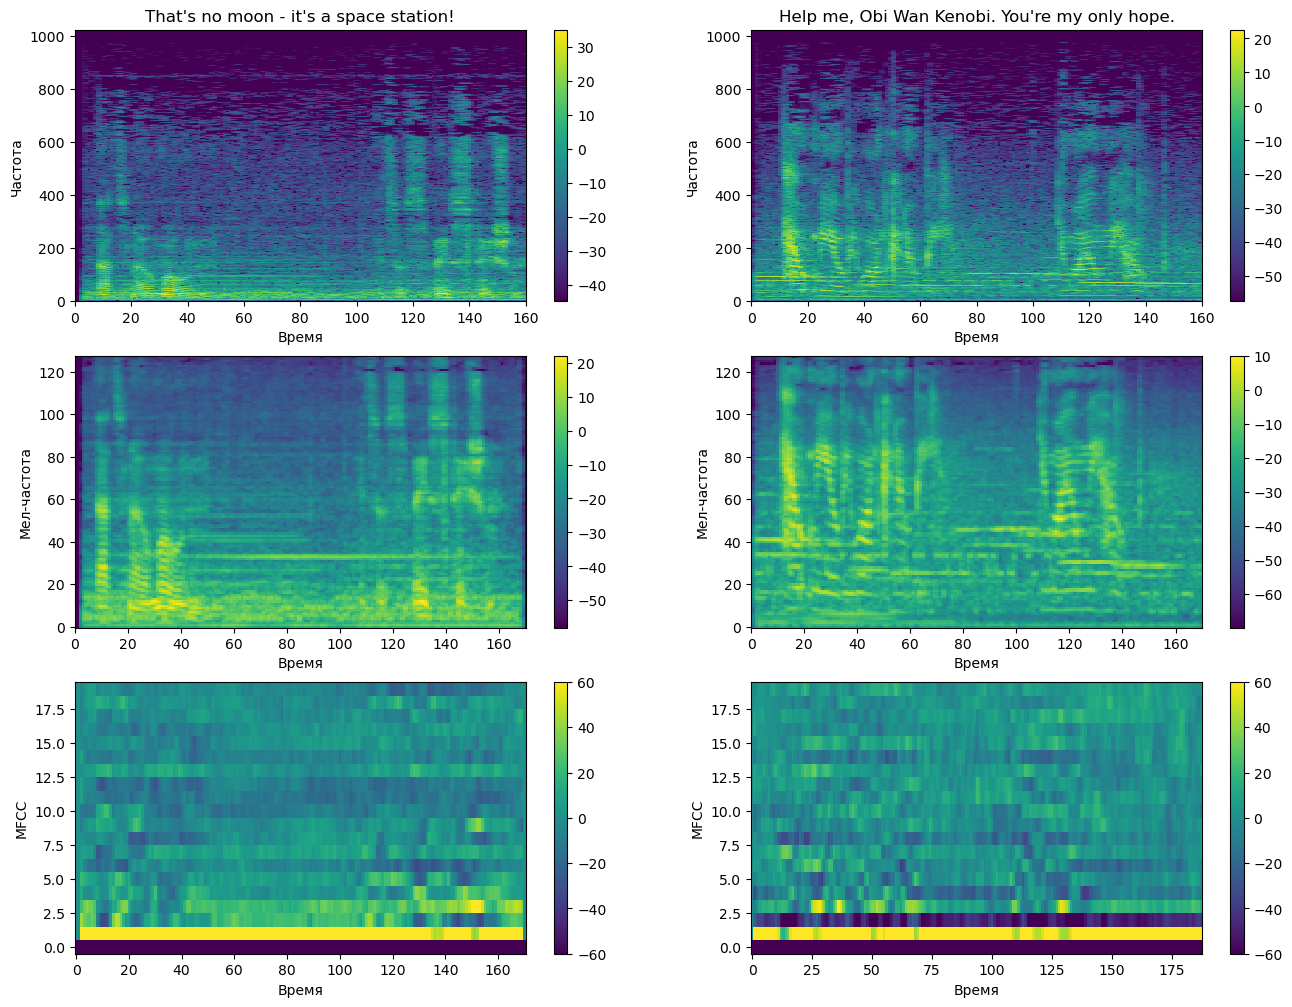

In [76]:
# Сравнение спектрограмм, мел-спектрограмм и MFCC для двух аудиосэмплов

# Создаём график с 6 подграфиками
plt.figure(figsize=[16, 12])

# --- Спектрограмма мощности для первого сэмпла ---
plt.subplot(3, 2, 1)
plt.title("That's no moon - it's a space station!")  # Заголовок графика
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Частота")  # Ось Y — частотная ось
# Отображаем спектрограмму мощности в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_spectrogram(amplitudes1)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 160)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- Спектрограмма мощности для второго сэмпла ---
plt.subplot(3, 2, 2)
plt.title("Help me, Obi Wan Kenobi. You're my only hope.")  # Заголовок графика
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Частота")  # Ось Y — частотная ось
# Отображаем спектрограмму мощности в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_spectrogram(amplitudes2)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 160)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- Мел-спектрограмма для первого сэмпла ---
plt.subplot(3, 2, 3)
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Мел-частота")  # Ось Y — мел-частотная ось
# Отображаем мел-спектрограмму в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_melspectrogram(amplitudes1)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 170)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- Мел-спектрограмма для второго сэмпла ---
plt.subplot(3, 2, 4)
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Мел-частота")  # Ось Y — мел-частотная ось
# Отображаем мел-спектрограмму в логарифмической шкале (dB)
plt.imshow(
    librosa.power_to_db(get_melspectrogram(amplitudes2)),  # Преобразуем мощность в децибелы
    origin='lower',  # Начало оси Y внизу
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.xlim(0, 170)  # Ограничиваем временной диапазон
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- MFCC для первого сэмпла ---
plt.subplot(3, 2, 5)
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("MFCC")  # Ось Y — коэффициенты MFCC
# Отображаем MFCC
plt.imshow(
    get_MFCC(amplitudes1, n_mfcc=20),  # Вычисляем MFCC с 20 коэффициентами
    origin='lower',  # Начало оси Y внизу
    vmin=-60, vmax=60,  # Задаём диапазон значений для цвета
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# --- MFCC для второго сэмпла ---
plt.subplot(3, 2, 6)
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("MFCC")  # Ось Y — коэффициенты MFCC
# Отображаем MFCC
plt.imshow(
    get_MFCC(amplitudes2, n_mfcc=20),  # Вычисляем MFCC с 20 коэффициентами
    origin='lower',  # Начало оси Y внизу
    vmin=-60, vmax=60,  # Задаём диапазон значений для цвета
    interpolation='nearest',  # Без сглаживания между точками
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# Отображаем все подграфики
plt.show()


## Часть 2: Реконструкция аудио из речевых представлений

### Из мел-спектограммы в частотную спектограмму

Для восстановления частотной спектрограммы из мел-спектрограммы используется [псевдообратная матрица Мура-Пенроуза](https://ru.wikipedia.org/wiki/Псевдообратная_матрица). Соотношение выглядит следующим образом:

$$
\hat{\mathbf{S}} = (\mathbf{F}^T\mathbf{F})^{-1}\mathbf{F}^T\mathbf{M}
$$

In [84]:
# Обратное преобразование MFCC в мел-спектрограмму
def inv_MFCC(MFCCs):
    """
    Преобразует MFCC обратно в мел-спектрограмму.
    
    :param MFCCs: array [n_mfcc, duration] — массив мел-частотных кепстральных коэффициентов
    :returns: mel_spectrogram [n_mfcc, duration] — восстановленная мел-спектрограмма
    """
    # Шаг 1: Применяем обратное дискретное косинусное преобразование (IDCT)
    # Используем IDCT (обратное преобразование) для восстановления логарифмической мел-спектрограммы (в dB)
    # - type=2: используем второй тип DCT, обратный к прямому
    # - axis=0: восстанавливаем значения вдоль оси мел-частот
    # - norm='ortho': ортонормированная нормализация, как и в прямом преобразовании
    db_spec = sp.fftpack.idct(MFCCs, type=2, n=None, axis=0, norm='ortho')

    # Шаг 2: Преобразуем логарифмическую мел-спектрограмму (в dB) в линейную мощность
    # Используем функцию librosa.db_to_power для восстановления спектра мощности
    mel_spectrogram = librosa.db_to_power(db_spec)
    
    # Возвращаем восстановленную мел-спектрограмму
    return mel_spectrogram

In [86]:
# Восстановление спектрограммы мощности из мел-спектрограммы
def inv_mel_spectrogram(mel_spectrogram, n_mels, sample_rate=22050,
                        window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Восстанавливает спектрограмму мощности частот из мел-спектрограммы мощности.
    
    :param mel_spectrogram: array [n_mels, duration] — мел-спектрограмма мощности
    :param n_mels: int — количество мел-компонент
    :param sample_rate: int — частота дискретизации (число отсчётов в секунду)
    :param window_length: int — длина окна для FFT
    :param hop_length: int — шаг между соседними окнами
    :param fmin: float — минимальная частота (в Гц)
    :param fmax: float — максимальная частота (в Гц)
    :returns: frequency_spectrogram: array [n_mels, duration] — восстановленная спектрограмма мощности частот
    """
    # Импортируем функцию для обратного преобразования из librosa
    from librosa.feature.inverse import mel_to_stft

    # Восстанавливаем спектрограмму мощности частот из мел-спектрограммы мощности
    # mel_to_stft принимает мел-спектрограмму и восстанавливает спектрограмму мощности частот
    # Параметр `sr` задаёт частоту дискретизации сигнала
    return mel_to_stft(mel_spectrogram, sr=sample_rate)

In [128]:
# Сверимся с librosa

amplitudes1, s1 = librosa.core.load("./sample1.wav")
amplitudes2, s2 = librosa.core.load("./sample2.wav")

res1 = inv_mel_spectrogram(get_melspectrogram(amplitudes1, window_length=2048, hop_length=512), n_mels=128, sample_rate=s1)
res2 = inv_mel_spectrogram(get_melspectrogram(amplitudes2, window_length=2048, hop_length=512), n_mels=128, sample_rate=s2)

# Вычисляем спектрограммы мощности для обоих сигналов
ref1, _ = magnitude_spectrogram(y=amplitudes1, win_length=2048)
ref2, _ = magnitude_spectrogram(y=amplitudes2, win_length=2048)

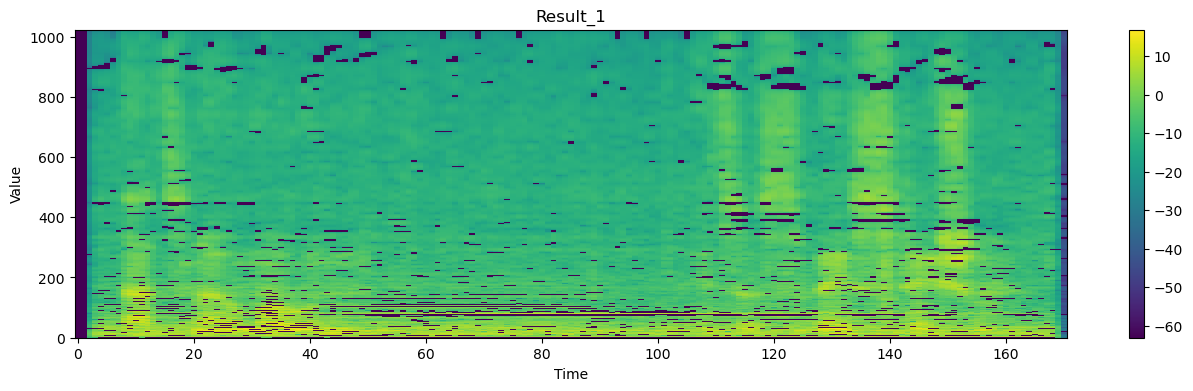

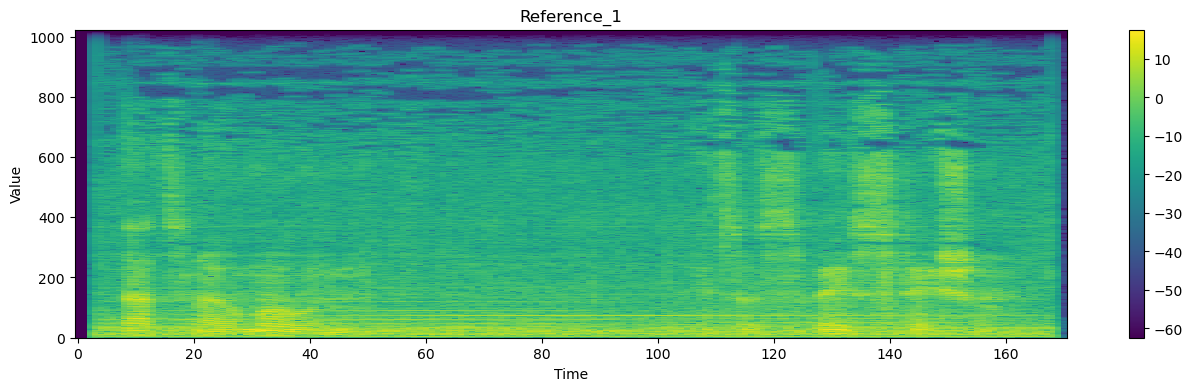

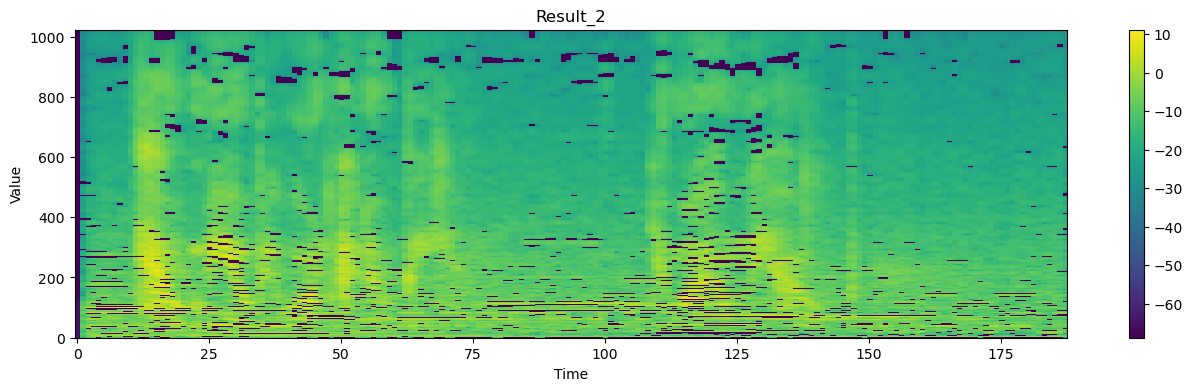

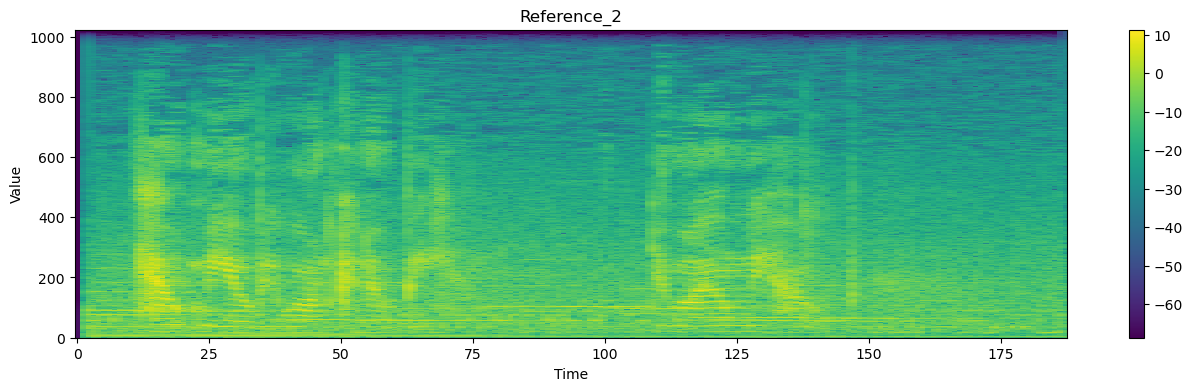

In [130]:
plot_spectrogram(librosa.power_to_db(res1), text = "Result_1")
plot_spectrogram(librosa.power_to_db(ref1), text = "Reference_1")
plot_spectrogram(librosa.power_to_db(res2), text = "Result_2")
plot_spectrogram(librosa.power_to_db(ref2), text = "Reference_2")
plt.close()

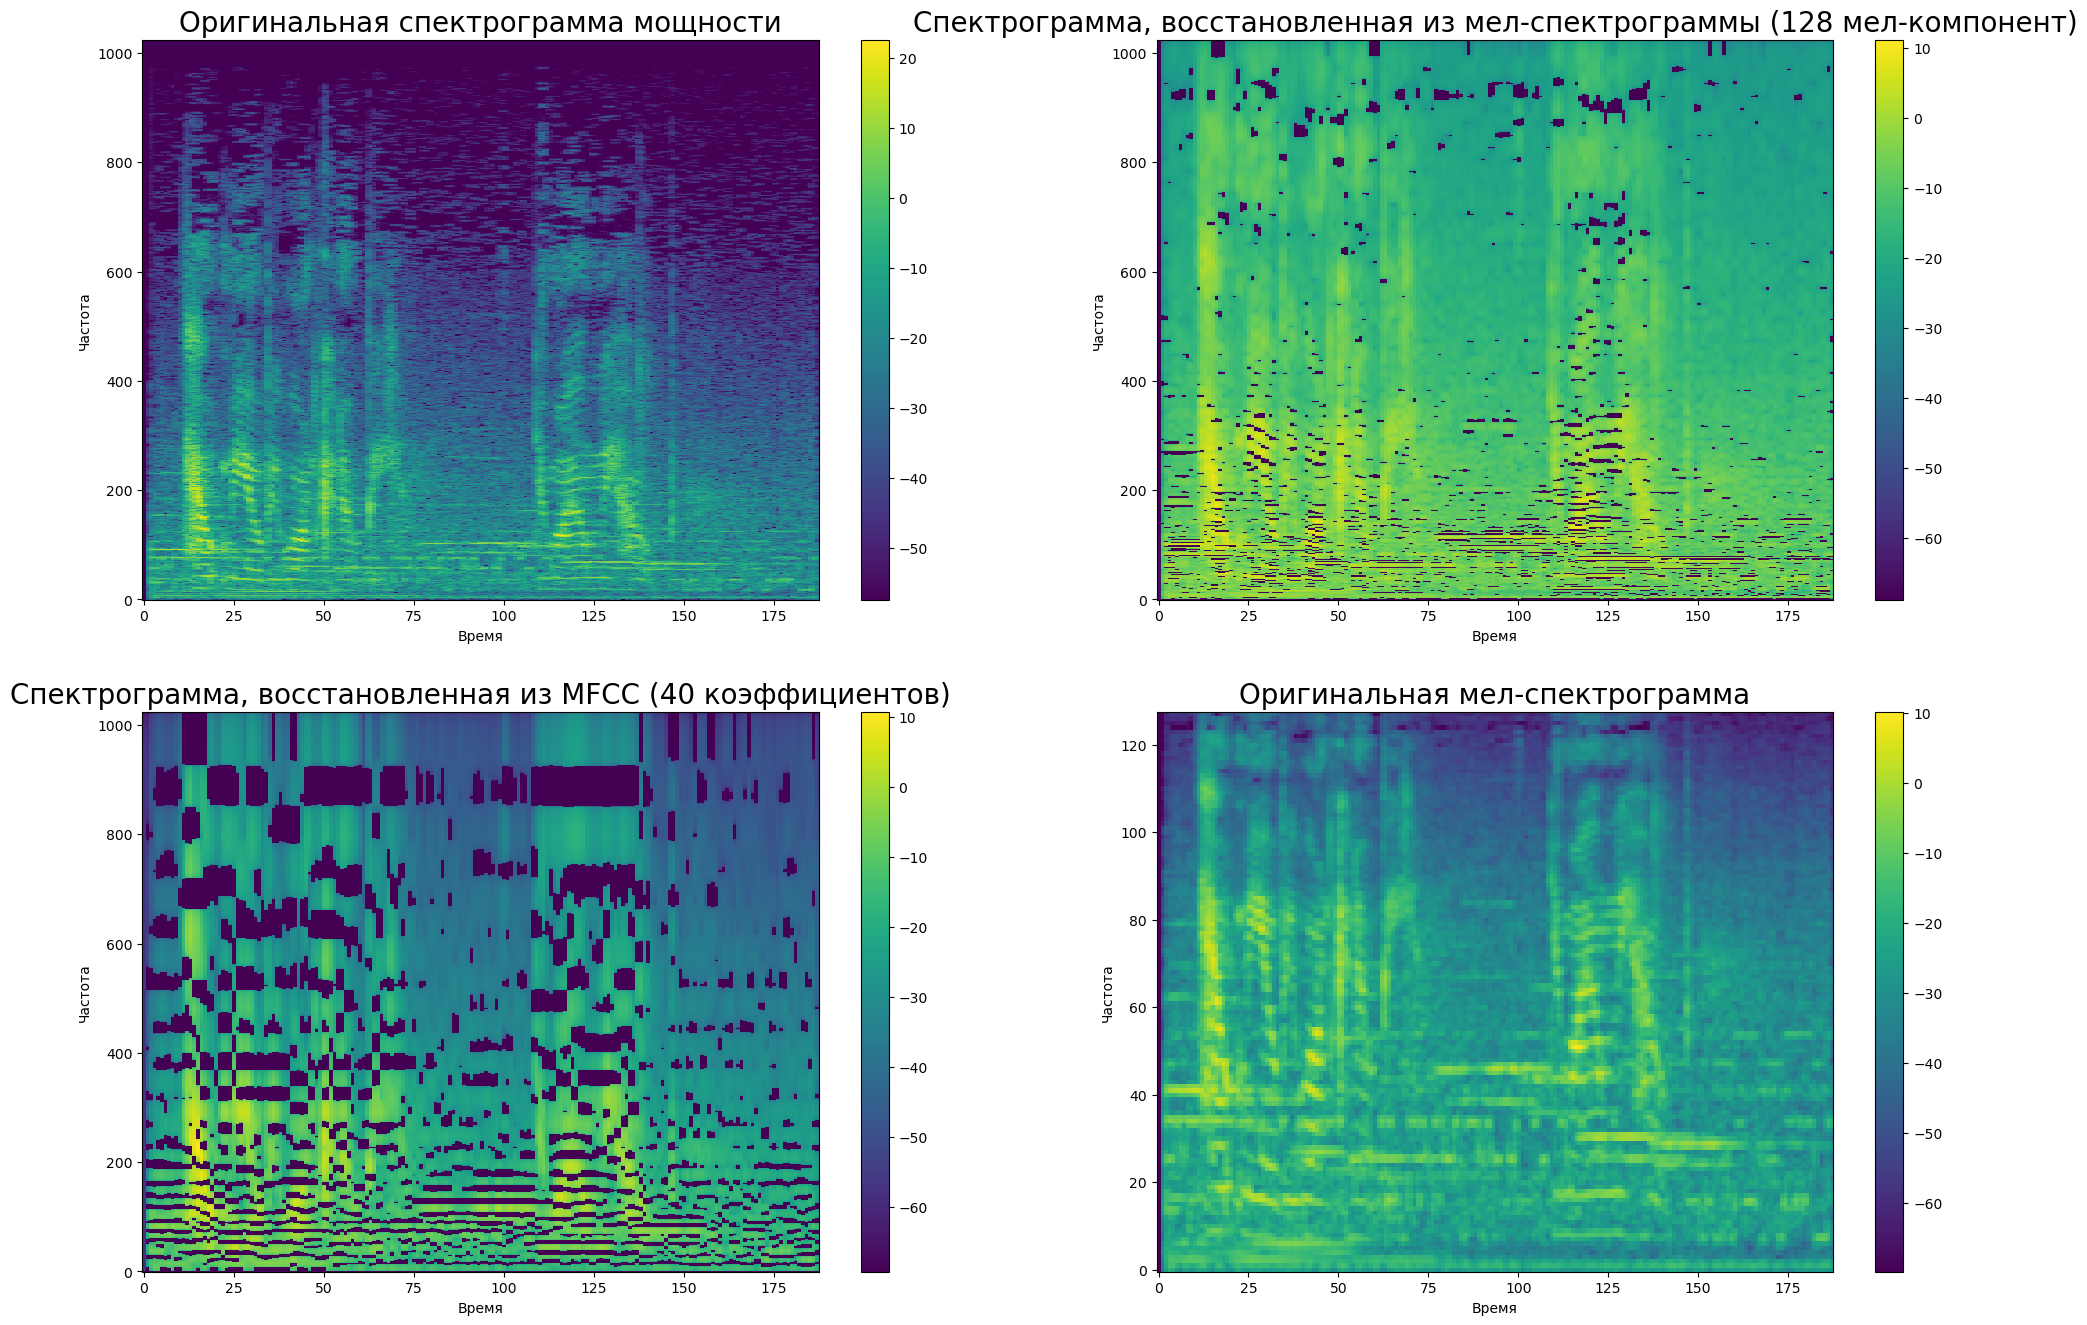

In [132]:
# Загружаем аудиофайл и получаем амплитуды сигнала и частоту дискретизации
amplitudes, sample_rate = librosa.core.load("sample2.wav")

# Вычисляем исходную спектрограмму мощности
true_spec = get_spectrogram(amplitudes)

# Вычисляем мел-спектрограмму из амплитуд
mel_spec = get_melspectrogram(amplitudes, n_mels=128, window_length=2048, hop_length=512)

# Вычисляем MFCC (40 коэффициентов) из амплитуд
MFCCs = get_MFCC(amplitudes, n_mfcc=40)

# Конвертируем данные обратно:

# Восстанавливаем мел-спектрограмму из MFCC
rec_mel_spec = inv_MFCC(MFCCs)

# Восстанавливаем спектрограмму мощности из мел-спектрограммы (128 мел-компонент)
rec_spec = inv_mel_spectrogram(mel_spec, window_length=2048, hop_length=512, n_mels=128, fmax=8000)

# Восстанавливаем спектрограмму мощности из мел-спектрограммы, полученной из MFCC (40 мел-компонент)
rec_mfcc_spec = inv_mel_spectrogram(rec_mel_spec, n_mels=40)

# Визуализация результатов
plt.figure(figsize=[24, 16])

# Оригинальная спектрограмма мощности
plt.subplot(2, 2, 1)
plt.title("Оригинальная спектрограмма мощности", fontsize=20)  # Заголовок
plt.xlabel("Время")  # Ось X — временная ось
plt.ylabel("Частота")  # Ось Y — частотная ось
plt.imshow(
    librosa.power_to_db(true_spec),  # Конвертируем мощность в dB для визуализации
    origin='lower',  # Ось Y начинается снизу
    interpolation='nearest',  # Без интерполяции
    aspect='auto'  # Автоматическое соотношение сторон
)
plt.colorbar(use_gridspec=True)  # Добавляем цветовую шкалу

# Спектрограмма, восстановленная из мел-спектрограммы (128 мел-компонент)
plt.subplot(2, 2, 2)
plt.title("Спектрограмма, восстановленная из мел-спектрограммы (128 мел-компонент)", fontsize=20)  # Заголовок
plt.xlabel("Время")  # Ось X
plt.ylabel("Частота")  # Ось Y
plt.imshow(
    librosa.power_to_db(rec_spec),  # Конвертируем мощность в dB
    origin='lower',
    interpolation='nearest',
    aspect='auto'
)
plt.colorbar(use_gridspec=True)

# Спектрограмма, восстановленная из MFCC (40 коэффициентов)
plt.subplot(2, 2, 3)
plt.title("Спектрограмма, восстановленная из MFCC (40 коэффициентов)", fontsize=20)  # Заголовок
plt.xlabel("Время")  # Ось X
plt.ylabel("Частота")  # Ось Y
plt.imshow(
    librosa.power_to_db(rec_mfcc_spec),  # Конвертируем мощность в dB
    origin='lower',
    interpolation='nearest',
    aspect='auto'
)
plt.colorbar(use_gridspec=True)

# Оригинальная мел-спектрограмма
plt.subplot(2, 2, 4)
plt.title("Оригинальная мел-спектрограмма", fontsize=20)  # Заголовок
plt.xlabel("Время")  # Ось X
plt.ylabel("Частота")  # Ось Y
plt.imshow(
    librosa.power_to_db(mel_spec),  # Конвертируем мощность в dB
    origin='lower',
    interpolation='nearest',
    aspect='auto'
)
plt.colorbar(use_gridspec=True)

# Отображаем все графики
plt.show()


### Алгоритм Гриффина-Лима (GLA)

Напомнню, что при построении спектрограммы, которая содержит только величины STFT, **информация о фазе** выбрасывается. Чтобы восстановить исходный сигнал с помощью обратного преобразования Фурье, нам нужно каким-то образом восстановить эту фазовую информацию.

Очевидно, что сделать это из **единственного** акустического кадра невозможно – эта информация исчезла. Однако спектрограмма (последовательность акустических кадров) является **избыточной**, поскольку акустические кадры вычисляются из **перекрывающихся окон** и, следовательно, **совместно** содержат информацию о фазе.

---

#### Как работает алгоритм Гриффина-Лима?

GLA использует избыточность спектрограммы для восстановления фазовой информации. Основная идея заключается в обеспечении **согласованности** спектрограммы путём итеративного применения двух проекций. Процесс можно описать так:

1. **Создание комплексного сигнала**  
   В частотной области создаётся комплексный сигнал, используя амплитуды из спектрограммы.

2. **Обратное преобразование Фурье**  
   Выполняется обратное преобразование Фурье, чтобы восстановить временной сигнал.

3. **Прямое преобразование Фурье**  
   Полученный временной сигнал снова преобразуется в частотное пространство. При этом обновляется фазовая информация, но амплитуды могут быть искажены.

4. **Замена амплитуд**  
   Искажённые амплитуды заменяются на оригинальные амплитуды из спектрограммы.

5. **Итерации**  
   Процесс повторяется до тех пор, пока амплитуды оригинальной спектрограммы и восстановленной не станут согласованными.

---

#### Ограничения алгоритма

- **Медленная сходимость**  
  Алгоритм Гриффина-Лима может требовать большое количество итераций для достижения согласованности спектрограммы.

- **Низкое качество реконструкции**  
  GLA основывается только на согласованности, не используя никакой информации о характеристиках целевого сигнала. Это может приводить к потере качества при восстановлении.

---

Несмотря на свою простоту, алгоритм Гриффина-Лима часто используется для восстановления аудиосигнала из спектрограммы. Однако из-за его ограничений в сходимости и качестве реконструкции существуют более сложные методы, которые учитывают свойства целевого сигнала.

In [104]:
# Восстановление амплитуд сигнала из STFT
def get_iSTFT(stft_matrix, window_length=2048, hop_length=512):
    """ 
    Вычисляет обратное кратковременное преобразование Фурье (iSTFT)
    :param stft_matrix: complex array [n_frequencies, duration] — STFT-матрица
    :param window_length: int — длина окна, к которому применяется FFT
    :param hop_length: int — шаг между соседними окнами
    :returns amplitudes: float [num_amplitudes] — временной ряд амплитуд звука
    """
    # Проверяем, что входные данные имеют тип complex
    assert stft_matrix.dtype == complex

    # Создаём окно Ханна для обратного преобразования
    # Это весовая функция, которая сглаживает края каждого окна
    window = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)

    # Вычисляем параметры исходного сигнала
    n_fft = 2 * (stft_matrix.shape[-2] - 1)  # Число точек FFT
    n_frames = stft_matrix.shape[-1]  # Число временных окон
    expected_signal_len = hop_length * (n_frames - 1) + n_fft  # Ожидаемая длина восстановленного сигнала

    # Инициализируем массив для амплитуд сигнала
    amplitudes = np.zeros(expected_signal_len)

    # Восстанавливаем временной ряд из каждого окна STFT
    for n, i in enumerate(range(0, len(amplitudes) - n_fft, hop_length)):
        # Обратное преобразование Фурье (IRFFT) для каждого окна
        # Применяем окно Ханна для сглаживания
        amplitudes[i:i + n_fft] += window * np.fft.irfft(stft_matrix.T[n])

    # Корректируем амплитуды с учётом перекрытия окон
    # Вычисляем сумму весов окна для каждой точки
    wss = librosa.filters.window_sumsquare(window='hann', n_frames=n_frames, hop_length=hop_length)

    # Нормализуем амплитуды, чтобы устранить эффекты перекрытия окон
    amplitudes /= wss

    # Удаляем дополнительный паддинг, добавленный на этапе STFT
    amplitudes = amplitudes[n_fft // 2:]  # Убираем паддинг в начале
    amplitudes = amplitudes[:-n_fft // 2]  # Убираем паддинг в конце

    return amplitudes


In [106]:
# Сверимся с librosa

amplitudes1, s1 = librosa.core.load("./sample1.wav")
amplitudes2, s2 = librosa.core.load("./sample2.wav")

ref1 = librosa.istft(librosa.stft(amplitudes1, win_length=2048, hop_length=512),  win_length=2048, hop_length=512, center=True)
ref2 = librosa.istft(librosa.stft(amplitudes2, win_length=2048, hop_length=512),  win_length=2048, hop_length=512, center=True)


res1 = get_iSTFT(get_STFT(amplitudes1))
res2 = get_iSTFT(get_STFT(amplitudes2))

assert np.allclose(res1, ref1, rtol=1e-2, atol=1e-2)
assert np.allclose(res2, ref2, rtol=1e-2, atol=1e-2)

/var/folders/89/bv65zp913xlglr6hq8_3m4j00000gn/T/ipykernel_41161/3975664907.py:36: RuntimeWarning: invalid value encountered in divide
  amplitudes /= wss


In [108]:
# Реализация алгоритма Гриффина-Лима для восстановления аудиосигнала из спектрограммы мощности
def griffin_lim(power_spectrogram, window_size, hop_length, iterations, seed=1, verbose=True):
    """
    Восстанавливает аудиосигнал из спектрограммы мощности, используя алгоритм Гриффина-Лима.
    Алгоритм описан в статье:
    "Signal estimation from modified short-time fourier transform" 
    by Griffin and Lim, IEEE transactions on Acoustics, Speech, and Signal Processing. Vol ASSP-32, No. 2, April 1984.

    :param power_spectrogram: array [n_frequencies, duration] — спектрограмма мощности
    :param window_size: int — длина окна для FFT
    :param hop_length: int — шаг между соседними окнами
    :param iterations: int — число итераций для алгоритма Гриффина-Лима (рекомендуется около 50)
    :param seed: int — случайное начальное значение для инициализации шума
    :param verbose: bool — выводить ли подробности работы алгоритма (ошибки RMSE на каждой итерации)
    :returns: x_reconstruct — восстановленный временной ряд амплитуд сигнала
    """

    # Вычисляем длину исходного временного ряда на основе параметров спектрограммы
    time_slices = power_spectrogram.shape[1]  # Число временных окон
    len_samples = int(time_slices * hop_length - hop_length)  # Длина временного ряда в отсчётах

    # Инициализируем спектрограмму амплитуд (модуль STFT) из входной спектрограммы мощности
    magnitude_spectrogram = power_spectrogram

    # Инициализируем восстановленный сигнал случайным шумом
    np.random.seed(seed)
    x_reconstruct = np.random.randn(len_samples)

    # Переменная для отслеживания предыдущей ошибки
    old_diff = np.inf

    # Итерационный процесс восстановления сигнала
    for n in range(iterations):
        # Вычисляем STFT текущего сигнала
        reconstruction_spectrogram = librosa.stft(x_reconstruct, win_length=window_size, hop_length=hop_length)

        # Извлекаем фазовую информацию из STFT (используем np.angle)
        reconstruction_angle = np.angle(reconstruction_spectrogram)

        # Заменяем амплитудную часть STFT на входную спектрограмму амплитуд
        proposal_spectrogram = magnitude_spectrogram * np.exp(1j * reconstruction_angle)
        assert proposal_spectrogram.dtype == complex  # Проверяем, что результат является комплексным числом

        # Сохраняем предыдущую реконструкцию
        prev_x = x_reconstruct

        # Восстанавливаем временной сигнал из новой STFT
        x_reconstruct = librosa.istft(proposal_spectrogram, win_length=window_size, hop_length=hop_length)

        # Вычисляем RMSE (среднеквадратичную ошибку) между текущим и предыдущим сигналом
        diff = np.sqrt(sum((x_reconstruct - prev_x) ** 2) / x_reconstruct.size)
        if verbose:
            # Выводим информацию о текущей итерации и RMSE
            print('Reconstruction iteration: {}/{} RMSE: {} '.format(n, iterations, diff))
            # Проверяем, что ошибка уменьшается
            assert diff < old_diff

        # Обновляем предыдущую ошибку
        old_diff = diff

    return x_reconstruct

In [110]:
# Восстанавливаем аудиосигнал из оригинальной спектрограммы

# С помощью алгоритма Гриффина-Лима, одна итерация
rec_amplitudes1 = griffin_lim(true_spec, window_size=2048, hop_length=512, iterations=1, verbose=False)
display(Audio(rec_amplitudes1, rate=sample_rate))  # Отображаем восстановленный звук

# С помощью алгоритма Гриффина-Лима, 100 итераций
rec_amplitudes2 = griffin_lim(true_spec, window_size=2048, hop_length=512, iterations=100, verbose=False)
display(Audio(rec_amplitudes2, rate=sample_rate))  # Отображаем восстановленный звук

# Восстанавливаем аудиосигнал из 128-мерной мел-спектрограммы

# С помощью алгоритма Гриффина-Лима, одна итерация
rec_amplitudes3 = griffin_lim(rec_spec, window_size=2048, hop_length=512, iterations=1, verbose=False)
display(Audio(rec_amplitudes3, rate=sample_rate))  # Отображаем восстановленный звук

# С помощью алгоритма Гриффина-Лима, 100 итераций
rec_amplitudes4 = griffin_lim(rec_spec, window_size=2048, hop_length=512, iterations=100, verbose=False)
display(Audio(rec_amplitudes4, rate=sample_rate))  # Отображаем восстановленный звук

# Восстанавливаем аудиосигнал из 20-мерных MFCC

# С помощью алгоритма Гриффина-Лима, одна итерация
rec_amplitudes5 = griffin_lim(rec_mfcc_spec, window_size=2048, hop_length=512, iterations=1, verbose=False)
display(Audio(rec_amplitudes5, rate=sample_rate))  # Отображаем восстановленный звук

# С помощью алгоритма Гриффина-Лима, 200 итераций
rec_amplitudes6 = griffin_lim(rec_mfcc_spec, window_size=2048, hop_length=512, iterations=200, verbose=False)
display(Audio(rec_amplitudes6, rate=sample_rate))  # Отображаем восстановленный звук


In [114]:
# Пример для librosa, но без MFCC потому что слишком много потерь

# На реальной спектограмме
ref_amplitudes1 = librosa.griffinlim(true_spec, n_iter=1, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes1, rate=sample_rate))
ref_amplitudes2 = librosa.griffinlim(true_spec, n_iter=50, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes2, rate=sample_rate))

# На реконструированной
ref_amplitudes3 = librosa.griffinlim(rec_spec, n_iter=1, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes3, rate=sample_rate))
ref_amplitudes4 = librosa.griffinlim(rec_spec, n_iter=50, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes4, rate=sample_rate))

# Спасибо за внимание!